# Task 3: Evaluierung 

In folgendem Abschnitt werden unsere Recommender hergestellt und getestet. Alle erstellten Funktionen und verwendete Bibliotheken befinden sich in unerer Helper-Datei 'p.py'. Dies erleichtert uns den Überblick über das gesammte Notebook.

In [4]:
# import functions and librarys from helper-file
from shits import *

## Daten einlesen & bereinigen
Wir lesen hier die Dateien ein und führen sie zusammen anhand der tmdbId --> So bekommen wir die entsprechende movieIds

In [5]:
# read data
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


Hier extrahieren wir die relevanten Daten aus den angegebenen Spalten, weil sie dort verschachtelt sind.

In [6]:
# extract data from dictionaries and list, separate key values by '|'
## extract function
def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))
## actual extraction
df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

Hier haben wir die Spalten definiert und geordnet, die wir benötigen (alle anderen wurden automatisch entfernt)

In [8]:
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "release_date", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
]
# reorder columns
df_movies = df_movies[col_order]

Wir entfernen Filme mit einer Laufzeit von unter 30 Minuten und über 300 Minuten, da wir für unseren Recommender keine Kurz - oder Langfilme beachten wollen.

In [9]:
# drop rows with runtime under 30 --> remove short films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] < 30].index)

# drop rows with runtime over 300 --> remove long films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] > 300].index)

Hier wurden die Daten weiter bereinigt; MovieId Duplikate und leere Filmbeschreibungen entfernt 

In [10]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset = df_movies.columns.difference(["movieId"]))

# remove all overviews that are nan
df_movies = df_movies.dropna(subset=["overview"])

Jetzt exportieren wir den bereinigten Dataframe, damit wir die enthaltenen Daten später bei der explorativen Datenanalyse untersuchen können.

In [11]:
# export df_movies to csv 
df_movies.to_csv('ml-25m/movies_clean.csv', index = False)

### Movie Ratings
Hier lesen wir die Filmbewertungen ein.

So können wir dann Bewertungen plausibilisieren --> falls diese Daten unmöglich sind (zb eine Bewertung wurde vor der Veröffentlichung vom Film erstellt), werden sie gelöscht.

In [12]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

Wir haben Filme von der TMDB API abgefragt und gespeichert (df_movies) und wir wollen jetzt nur die Bewertungen behalten, deren Filme dich in df_movies befinden. Darum schauen wir, ob die movieIds übereinstimmen, falls ja dann werden diese Bewertungen beibehalten. Alle andere Bewertungen werden automatisch gelöscht, da sie irrelevant sind.

In [13]:
# only keep movie ratings where the movieId is in df_movies
df_ratings = df_ratings[df_ratings["movieId"].isin(list(df_movies["movieId"]))]

Danach konvertieren wir die "timestamp" Spalte zu einem "datetime" Objekt und speichern das in einer neuen Spalte namens "date". Die Spalte "timestamp" wird anschliessend gelöscht.

In [14]:
# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop the old timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

Jetzt werden beide Dataframes zusammengeführt.

In [15]:
# merge movies and ratings on movieId
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

Wir müssen jetzt die Daten plausibilisieren.

Wir setzen dies um, indem wir Bewertungen löschen, welche vor dem Erscheinungsdatum abgegeben wurden.

In [16]:
# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

Hier ist ein weiteres Beispiel von Daten zu plausibilisieren; Wir schauen, ob es Users gibt, welche den gleichen Film mehrmals bewertet haben.

In [18]:
df_movies_ratings[df_movies_ratings.duplicated(subset = ["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries


Export von Datenbanken für seperates EDA ipynb.

In [152]:
df_movies_ratings.to_csv('ml-25m/df_movies_ratings.csv', index=False)

## NLP Implementierung

Was macht tf-idf mit Wörter, die überall vorkommen? 
- diese Wörter werden tief gewichtet

Was passiert mit Wörter die sehr selten sind? kann das Wort überahupt zur Ähnlichkeit beitragen?
- Wörter, die selten vorkommen haben ein höheres Score (höher bewertet)

Synonyme: Word2Vec (zb Auto --> PKW)

Verteilung der Ähnlichkeiten

aus dem text vektoren machen

was passiert mit dem cosinus similarity wenn wir die seltesten wörter abschneiden? besser? schlechter?

auf grund der häufigkeit matrix reduzieren

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

### Pre-Processing

#### Stemming von Wörtern

Bevor man mit einem NLP Algorithmus beginnt, müssen die Daten zuerst darauf vorbereitet werden (Pre-processed) - Dafür haben wir im File p.py eine Funktion "stemming_tokenizer" erstellt, die verschiedene Varianten eines Wortes auf ihren gemeinsamen Wortstamm zurückführt. Somit können einzelne Wörter und auch ganze Texte besser verglichen werden. Diese Funktion löscht zudem auch noch unnötige Symbole wie Kommas und Punkte und auch "stop words". Das sind z.B. Wörter wie "the", "a" ect.

In [27]:
# copy dataframe to avoid running the whole notebook again
df_movies_nlp = df_movies.copy().reset_index(drop = True)

# loop through the chosen columns and stem the words
for col in ["overview", "spoken_languages", "original_language", "production_companies", "production_countries"]:
    df_movies_nlp[col] = stemming_tokenizer(df_movies_nlp[col])

# create new title column with stemmed title (we don't want to stem the original title)
df_movies_nlp["new_title"] = stemming_tokenizer(df_movies_nlp["title"])

#### Kombinationsentscheid von Spalten für den perfekten Score

 Welche Attribute wollen wir für die Berechnung verwenden?
- Titel
- Overview
- Original Language
- Spoken Language
- Production Companies
- Production Countries




Wir programmieren eine Funktion, welche zufällig die Anzahl angegebene Spalten hinzufügt, um systematisch herauszufinden, welche Kombination von Spalten (Daten) die höchsten Scores / besten Vorschläge für die Filme hat. Die Funktion heisst "create_combinations" und ist im File "helper_file.py"

Hier rufen wir die Funktion auf und dabei wird ein Dataframe erstellt, die alle Filme mit 10 Filmvorschlägen ausgibt. Das Dataframe wird danach als csv exportiert und wieder eingelesen, damit wir die Funktion nicht immer ausführen müssen.

In [155]:
# get recommendations for each movie based on the combinations
#df_recommendations = recommendations_per_comb(df_movies_nlp, df_movies)

# sort the recommendations by score1
#df_recommendations.sort_values(by = ["movie", "score_1"], ascending = False)

# export dataframe to csv for later
#df_recommendations.to_csv("rec.csv", index = False)

In [22]:
# read the recommendations dataframe
rec = pd.read_csv("ml-25m/rec.csv", index_col = "Unnamed: 0")
rec.head()

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
0,"['new_title', 'overview', 'spoken_languages', ...",Venice,Panic Attack,0.154583,7 Things You Don't Know About Men,0.148710,Embassy,0.148499,Letters to Santa,0.139134,...,Women of Mafia 2,0.137449,Gods,0.134155,Hardkor Disko,0.130372,Breakfast in Bed,0.130297,Walpurgis Night,0.129467
1,"['new_title', 'overview', 'spoken_languages', ...",A Place at the Table,Food and Shelter,0.229952,Food Stamped,0.085962,The Anonymous People,0.084057,Mixed Doubles,0.074443,...,Food Choices,0.071564,Farmageddon,0.063199,Growing Cities,0.062772,Eating Animals,0.062322,Permanent,0.061547
2,"['new_title', 'overview', 'spoken_languages', ...",Kingdom Come,"Chronic-Con, Episode 420: A New Dope",0.069982,Kingdom Come,0.069428,Kevin Smith: Too Fat For 40,0.061588,Rats,0.052913,...,Barbie: Princess Charm School,0.047550,The Special Relationship,0.045128,"The Death of ""Superman Lives"": What Happened?",0.045053,Selma,0.042078,Wonder,0.042025
3,"['new_title', 'overview', 'spoken_languages', ...","Camille Claudel, 1915",Rodin,0.173721,Ducoboo 2: Crazy Vacation,0.124234,Oh Mercy,0.117102,Camille Rewinds,0.108202,...,Trophy Wife,0.096784,School Life,0.093823,House of Pleasures,0.091848,Eva,0.091395,My Golden Days,0.090107
4,"['new_title', 'overview', 'spoken_languages', ...",My Kingdom,White Vengeance,0.098080,The Final Master,0.080325,The Looming Storm,0.069230,Touch of the Light,0.066363,...,Buddha Mountain,0.058536,Bangkok Revenge,0.057755,The Black Devil and the White Prince,0.057549,Sword Master,0.056973,Master Z: Ip Man Legacy,0.056659


Wir erstellen hier eine neue Spalte, um die unique Kombinationen indexieren zu können.

In [23]:
## create new column based on the combination of the columns
rec["set_combination"] = rec.groupby("combination").ngroup()
rec["set_combination"].head()

0    9
1    9
2    9
3    9
4    9
Name: set_combination, dtype: int64

Von allen Kombinationen zeigen wir die Verteilung von den Scores vom Recommended Movie 1

c:\Users\David Dedic\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\David Dedic\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\David Dedic\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
c:\Users\David Dedic\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:848: FutureWarning: 

`

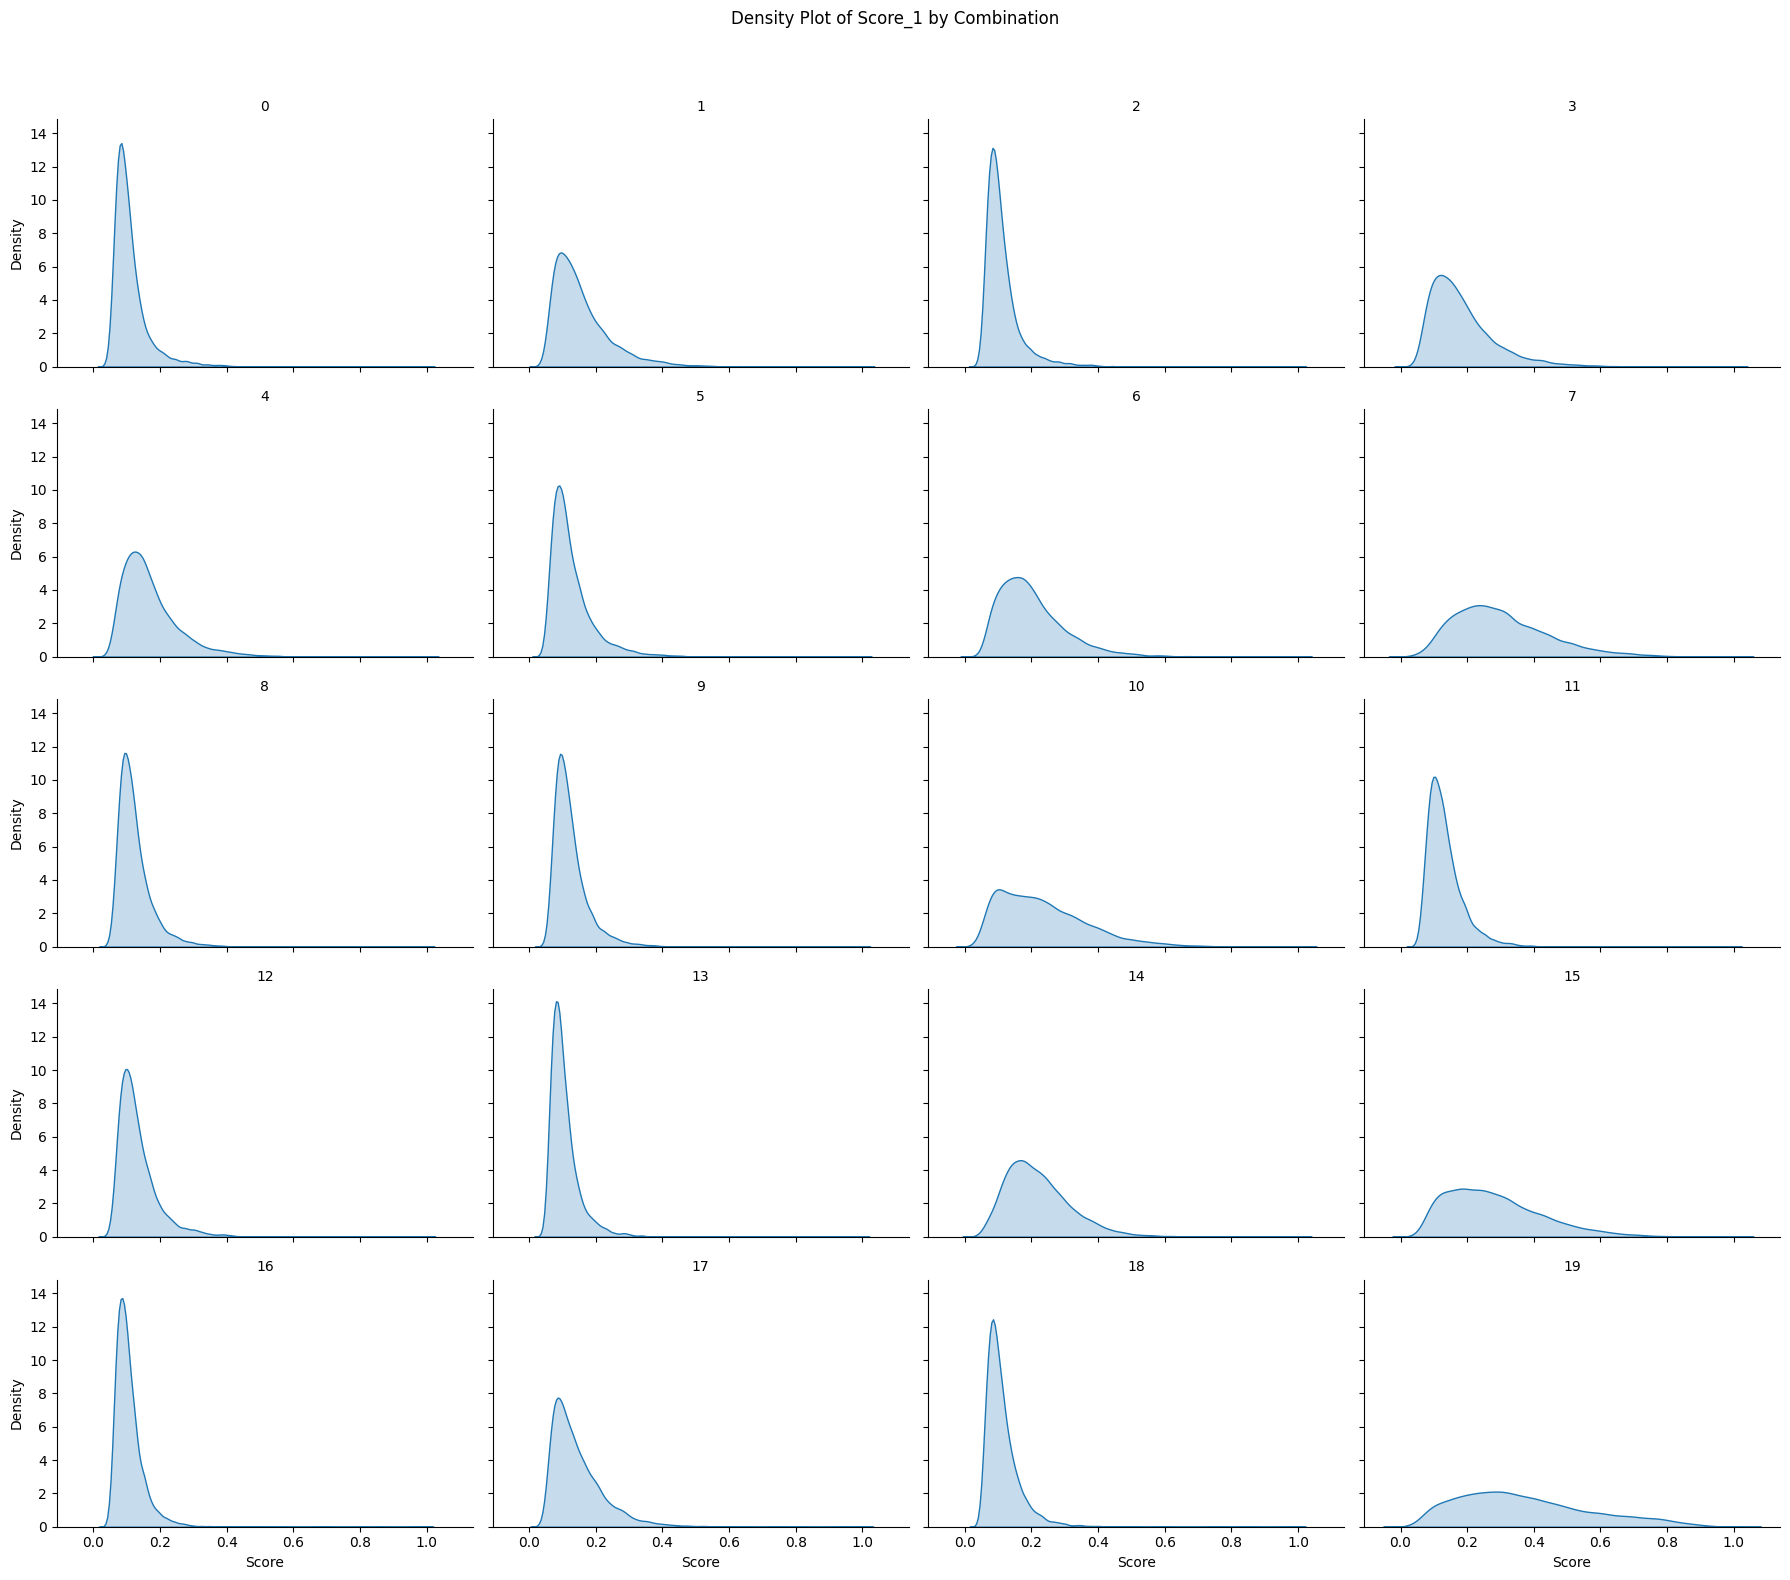

In [24]:
# facet wrap density plot for each combination
g = sns.FacetGrid(rec, col = "set_combination", col_wrap = 4, height = 3, aspect = 1.5)
g.map(sns.kdeplot, "score_1", shade = True)
g.set_titles(col_template = "{col_name}")
g.set_axis_labels("Score", "Density")
g.fig.suptitle("Density Plot of Score_1 by Combination", y = 1.05)
plt.show()

##### Kombination Entscheidung
Wir entscheiden uns für die Kombination 19, weil die Verteilung die höchsten Werte annimmt. Overview kommt 1 Mal vor, das bedeutet, dass die Wörter im Overview höcher bewertet werden (das Ziel ist es ja eher anhand des Overviews Filme vorzuschlagen)

In [29]:
# get the combinations where set_combination is 19
rec[rec["set_combination"] == 19]['combination'].unique()

array(["['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']"],
      dtype=object)

In [28]:
# cols from combination 19
cols = ['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']

Test auf Film "Fast & Furious 6"

In [25]:
## get the row with highest score_1 for the movie Fast & Furious 6
rec[rec["movie"] == "Fast & Furious 6"].sort_values(by = "score_1", ascending = False).head(1)

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
20788,"['new_title', 'overview', 'spoken_languages', ...",Fast & Furious 6,Furious 7,0.452835,The Fate of the Furious,0.442821,Fast Five,0.38839,Trainwreck,0.387489,...,0.371084,The Secret Life of Pets 2,0.301981,Survival Family,0.271846,"Rich Man, Poor Woman in New York",0.260465,Battle: Los Angeles,0.246985,19


## LSA
LSA (LAtent Semantic Analysis) auch bekannt als LSI (Latent Semantic Index) verwendet ein- Bag-of-Word-Modell (BoW), das zu einer Term-Dokument-Matrix führt (Vorkommen von Begriffen in einem Dokument)

Die Zeilen stehen für Begriffe und die Spalten für Dokumente. LSA lernt latente Themen, indem eine Matrixzerlegung der Dokument-Term-Matrix unter Verwendung der Singulärwertzerlegung durchgeführt wird. LSA Wird in der Regel zur Dimensionsreduzierung eingesetzt.

### SVD (Singular Value Decomposition) - Singulärwertzerlegung
SVD ist eine Matrixfaktorisierungsmethode, die eine Matrix als Produkt zweier Matrizen darstellt.

A: Input data matrix
m x n matrix (m documents, n terms)

U: Left singular vectors
m x r matrix (m documents, r concepts)

Sigma: Singular values
r x r diagonal matrix

V: Right singular vectors
n x r matrix (n terms, r concepts)

In [162]:
# recommend top 5 movies based on the the following movies: "Fast & Furious 6", "Interstellar"
recommendations_lsa = lsa_final(["Fast & Furious 6", "Interstellar"], df_movies_nlp, cols)
print(recommendations_lsa)

['Event 15', 'The Sunshine Makers', 'Killers Anonymous', 'Absolutely Anything', 'The Amazing Johnathan Documentary']


## Doc2Vec

Vector size: The vector size is the length of the learned word vectors. A larger vector size can capture more information about the words and documents, but may also require more computational resources and data to train.

Window size: The window size is the number of words around a target word that are used to predict the target word. A larger window size can capture more context for each word, but may also require more data to train.

Number of epochs: The number of epochs is the number of times the model is trained on the dataset. A larger number of epochs can improve the model's performance, but may also increase the training time.

Minimum word count: The minimum word count is the minimum number of times a word must appear in the dataset to be included in the model. A higher minimum word count can reduce the size of the model and improve its performance, but may also exclude useful information.

Sample: This parameter controls the downsampling of frequent words during training. Words that appear very frequently in the dataset, such as stop words, can dominate the training process and reduce the model's ability to learn meaningful embeddings for other words. Setting a high sample value can help mitigate this issue.

In [30]:
def create_doc2vec_model(documents):
    # Create a Doc2Vec model
    model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
    # Build a Volabulary
    model.build_vocab(documents)
    # Train the model
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

    return model

In [31]:
df_movies_nlp_d2v = df_movies_nlp.copy()
df_movies_nlp_d2v["D2V"] = df_movies_nlp_d2v[cols].apply(" ".join, axis=1)

In [34]:
data_for_training = list(tagged_document(df_movies_nlp_d2v["D2V"], df_movies_nlp_d2v['movieId']))

Parameter beschreiben!

In [33]:
model = Doc2Vec(data_for_training, vector_size=90, window=5, min_count=1, workers=4)

KeyboardInterrupt: 

In [411]:
def get_recommendations(tagged_documents, title, n):
    """Gets movie recommendations using a Doc2Vec model."""  

    # get id of movie title
    movie_id = df_movies_nlp[df_movies_nlp["title"] == title]["movieId"].values[0]

    # from tagged_documents get words where tags = movie_id
    word_list = [word for word, tag in tagged_documents if tag == movie_id]

    # flatten list
    word_list = [item for sublist in word_list for item in sublist]

    # infer vector of movie overview
    word_list_vectorized = model.infer_vector(word_list)

    # get cosine similarity of movie overview with all other movie overviews
    similar_sentences = model.docvecs.most_similar([word_list_vectorized], topn = n)

    # sort by score
    similar_sentences = sorted(similar_sentences, key = lambda x: x[1], reverse = True)

    # exclude 1st recommendation (movie itself)
    similar_sentences = similar_sentences[1:]

    # get movie ids of similar sentences
    similar_sentences = [movie_id for movie_id, score in similar_sentences]

    # get movie titles of similar sentences
    recommendations = df_movies_nlp[df_movies_nlp["movieId"].isin(similar_sentences)]["title"].values

    return recommendations[:5]

title = "Toy Story 3"

recommendations = get_recommendations(data_for_training, title, 11)
print(f'Recommendations for "{title}": {recommendations}')

Recommendations for "Toy Story 3": ['Sparrows Dance' 'Fun Size' 'Tammy' 'Go for It!' 'Afterparty']


C:\Users\Alex\AppData\Local\Temp/ipykernel_2972/3874469363.py:19: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_sentences = model.docvecs.most_similar([word_list_vectorized], topn = n)


## TFIDF

In [49]:
# recommend top 5 movies based on the the following movies: "Fast & Furious 6", "Interstellar"
recommendations_tfidf = recommendations_tfidf_final(df_movies_nlp,["Fast & Furious 6", "Interstellar"], cols)
print(recommendations_tfidf)

['Furious 7', 'The Fate of the Furious', 'Fast Five', 'Trainwreck', 'The Secret Life of Pets']


## Train Test Split

Wir wenden jetzt die Train-Test-Split Methode an, um die Leistung unserer Modelle zu bewerten. Wir teilen dabei die Daten in 2 Datensätze auf: Training & Test. Den Trainingssatz verwenden wir, um das Modell zu trainieren, während der Testsatz dazu verwendet wird, die Leistung des Modells anhand unsichtbarer Daten zu bewerten. Dies ist wichtig, da wir wissen möchten, wie gut mein Modell mit neuen, zuvor nicht sichtbaren Daten funktioniert.

Wir eliminieren alle Users, die weniger als 50 Bewertungen abgegeben haben --> damit wir genug Daten für den Train Test Split haben.

In [50]:
users = df_movies_ratings["userId"].value_counts()[df_movies_ratings["userId"].value_counts() > 49].index.tolist()

Danach passen wir das Dataframe an nur mit den oben definierten Users.

In [51]:
df_ratings_50 = df_movies_ratings[df_movies_ratings["userId"].isin(users)]

Für den Train Datensatz nehmen wir einen Sample von 80% der Daten. Die restlichen 20% werden dem Test Datensatz zugewiesen, indem alle Train Daten gelöscht werden.

In [52]:
train = df_ratings_50.groupby("userId").sample(frac=0.8, random_state=42)
test = df_ratings_50.drop(train.index)

Wir erstellen hier eine User-Item-Matrix mit dem userId als Index und movieId als Spalten und die jeweiligen Filmbewertungen als Werte vom Trainings Datensatz.

Die Matrix wird dazu verwendet, die Beziehungen zwischen Users und Items darzustellen und zu analysieren, um personalisierte Empfehlungen für Benutzer zu generieren und Vorhersagen über ihre Bewertungen von Artikeln zu treffen.

In [53]:
# create user-item-movie matrix with userId as index and movieId as columns and rating as values
df_user_movie_matrix_train = train.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

Jetzt wird aus dem User-Item-Matrix eine binäre User-Liked-Matrix erzeugt. Wir haben uns dazu für eine binäre User-Liked-Matrix entschieden, vor allem wegen der Einfachheit: Somit ist es für uns sehr einfach zu sehen, welche Filme einem User gefallen haben.

In der Explorativen Datenanalyse haben wir festgestellt, dass der Durchschnitt aller Bewertungen etwa bei einer 3 ist. Deswegen haben wir uns entschieden die 3 als Richtwert zu nehmen, sprich alle Filme mit den Bewertungen von über 3 gefielen dem User und alle unter oder gleich 3 gefielen dem User nicht. 

Postitive Bewertungen (>3) werden zu 1 und negative Bewertungen (<=3) werden zu 0.

In [54]:
df_user_movie_matrix_train[df_user_movie_matrix_train <= 3] = 0
df_user_movie_matrix_train[df_user_movie_matrix_train > 3] = 1

df_user_movie_matrix_train

movieId,895,2679,4249,4484,5904,47237,47962,71677,72491,73319,...,209049,209051,209053,209073,209085,209119,209129,209131,209133,209163
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Beim Testdatensatz wird dasselbe gemacht wie oben beim Trainingsdatensatz.

In [55]:
df_user_movie_matrix_test = test.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

In [56]:
df_user_movie_matrix_test[df_user_movie_matrix_test <= 3] = 0
df_user_movie_matrix_test[df_user_movie_matrix_test > 3] = 1

df_user_movie_matrix_test

movieId,4484,47237,47962,71677,72491,73319,73321,73929,74131,74135,...,208765,208773,208787,208800,208843,208887,208907,208915,208945,209041
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wie viele Nullstellen in Train und Test??

In [57]:
# calculate percentage of 0 in train and test set
print(f"Percentage of 0 in train set: {round((df_user_movie_matrix_train == 0).sum().sum() / (df_user_movie_matrix_train.shape[0] * df_user_movie_matrix_train.shape[1]) * 100, 2)}%")
print(f"Percentage of 0 in test set: {round((df_user_movie_matrix_test == 0).sum().sum() / (df_user_movie_matrix_test.shape[0] * df_user_movie_matrix_test.shape[1]) * 100, 2)}%")

Percentage of 0 in train set: 99.59%
Percentage of 0 in test set: 99.85%


In [58]:
# get all liked train movies per user
liked_movies_train = {}
for user in df_user_movie_matrix_train.index:
    liked_movies_train[user] = df_user_movie_matrix_train.columns[df_user_movie_matrix_train.loc[user] == 1].tolist()

In [59]:
## get all liked test movies per user
liked_movies_test = {}
for user in df_user_movie_matrix_test.index:
    liked_movies_test[user] = df_user_movie_matrix_test.columns[df_user_movie_matrix_test.loc[user] == 1].tolist()

In [60]:
## get users which do not have any liked movies in test and train set
users_to_remove = []
for user in liked_movies_train:
    if len(liked_movies_train[user]) == 0 or len(liked_movies_test[user]) == 0:
        users_to_remove.append(user)

In [61]:
#remove empty liked movies from both dictionaries
for user in users_to_remove:
    liked_movies_train.pop(user, None)
    liked_movies_test.pop(user, None)

In [62]:
# get name of movies in dictionary
train_movies = {}
for user in liked_movies_train:
    train_movies[user] = df_movies[df_movies["movieId"].isin(liked_movies_train[user])]["title"].tolist()

# get name of movies in dictionary
test_movies = {}
for user in liked_movies_test:
    test_movies[user] = df_movies[df_movies["movieId"].isin(liked_movies_test[user])]["title"].tolist()

In [63]:
# for every user get 10 movies from train set
for user in train_movies:
    train_movies[user] = list(set(train_movies[user]))[:10]

### Testing auf Userprofile

#### Dok2Vec

In [ ]:
def create_tagged_document(list_of_overviews, titles):
   """
   Creates a tagged document for each movie overview with the movie title as tag.

   Parameters:
      list_of_overviews (list): list of all overviews
      titles (list): list of titles

   Returns:
      list: list of tagged documents
   """
   for i, list_of_words in enumerate(list_of_overviews):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words.split(), [titles[i]])

In [478]:
def doc2vec_rec_user(df, split, cols):
    # create tfidf column with column combination
    df["doc2vec"] = df[cols].apply(" ".join, axis=1)

    tagged_document = list(create_tagged_document(df["doc2vec"], df['movieId']))

    model = Doc2Vec(tagged_document, vector_size=90, window=5, min_count=1, workers=4)

    testing_movies = {}

    count = 0

    for key, values in split.items():
        count += 1
        movie_lst = []
        print(count)
        for value in values:
            # get id of movie title
            movie_id = df[df["title"] == value]["movieId"].values[0]

            # from tagged_documents get words where tags = movie_id
            word_list = [word for word, tag in tagged_document if tag == movie_id]

            # flatten list
            word_list = [item for sublist in word_list for item in sublist]

            # infer vector of movie overview
            word_list_vectorized = model.infer_vector(word_list)

            # get cosine similarity of movie overview with all other movie overviews
            similar_sentences = model.docvecs.most_similar([word_list_vectorized], topn = 6)

            # sort by score
            similar_sentences = sorted(similar_sentences, key = lambda x: x[1], reverse = True)

            # exclude 1st recommendation (movie itself)
            similar_sentences = similar_sentences[1:]

            # get movie ids of similar sentences
            similar_sentences = [movie_id for movie_id in similar_sentences]

            movie_lst.append(similar_sentences)

        # flatten list
        movie_lst = [item for sublist in movie_lst for item in sublist]

        # sort list on score
        movie_lst = sorted(movie_lst, key=lambda x: x[1], reverse=True)

        # remove the score from movie list but keep the order
        movie_lst = [item[0] for item in movie_lst]

        # get movie titles
        movie_lst = df[df["movieId"].isin(movie_lst)]["title"].tolist()

        testing_movies[key] = movie_lst[:5]

    return testing_movies

In [ ]:
#testing_doc2vec = doc2vec_rec_user(df_movies_nlp, train_movies, cols)

In [70]:
# export testing_doc2vec to csv
#pd.DataFrame.from_dict(testing_doc2vec, orient='index').to_csv("testing_doc2vec.csv")

In [ ]:
# import testing_doc2vec from csv
testing_doc2vec324 = pd.read_csv("testing_doc2vec.csv", index_col=0).to_dict(orient="index")

In [ ]:
calculate_hits(testing_doc2vec, test_movies)

#### LSA

In [68]:
testing_lsa = lsa_rec_user(df_movies_nlp, train_movies, cols)

''

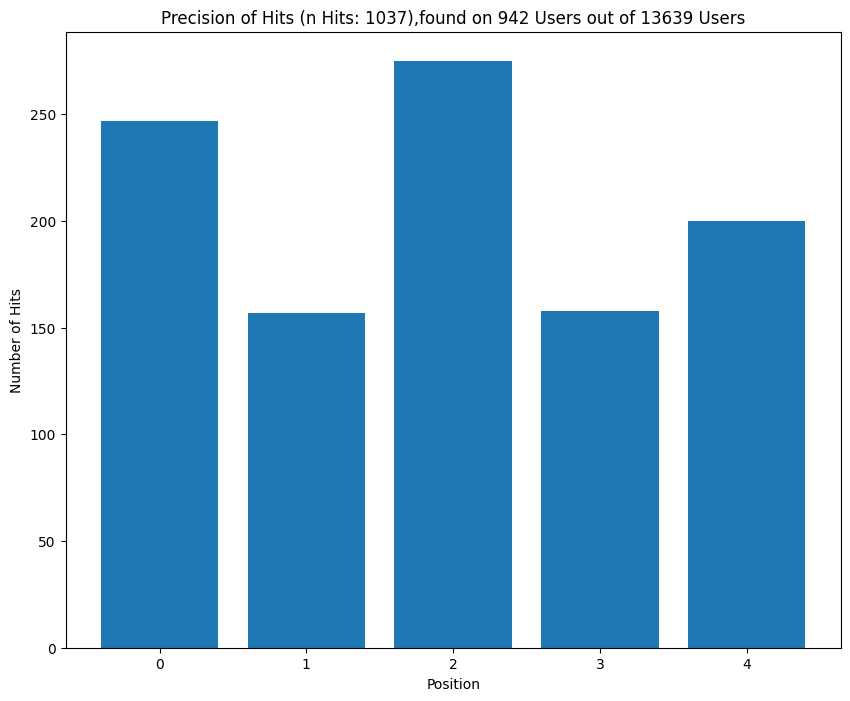

In [97]:
calculate_hits(testing_lsa, test_movies)

#### TFIDF

In [ ]:
testing_tfidf = tfidf_rec_user(df_movies_nlp, train_movies, cols)

1


C:\Users\Alex\AppData\Local\Temp/ipykernel_2972/4011155669.py:35: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_sentences = model.docvecs.most_similar([word_list_vectorized], topn = 6)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

{3: ['Shadows & Lies', 'Gone', 'Springsteen & I', 'Contracted', 'Tammy'],
 4: ['30 Days of Night: Dark Days',
  '2012: Time for Change',
  'The Sitter',
  'Let Fury Have the Hour',
  'The Traffic Department'],
 19: ['Animal Kingdom',
  'Gasland',
  'Country Strong',
  'Battle: Los Angeles',
  'Gantz'],
 75: ['Paranormal Activity 2',
  'The Next Three Days',
  'Another Year',
  'Cold Weather',
  'Jack and Jill'],
 84: ['Venice',
  '12th & Delaware',
  '2012: Time for Change',
  'The Kid with a Bike',
  'The Undefeated'],
 91: ['The Social Network',
  'The Ides of March',
  '50/50',
  'Young Adult',
  'Crime After Crime'],
 95: ['Paathshaala',
  'Country Strong',
  'Goon',
  'Sound of My Voice',
  'Atlas Shrugged: Part II'],
 113: ['30 Days of Night: Dark Days',
  'Another Year',
  'Ceremony',
  'The Sitter',
  'My Last Day Without You'],
 114: ['My Soul to Take',
  'The Sitter',
  'Kokowääh',
  'Crime After Crime',
  'Chernobyl Diaries'],
 119: ['Paranormal Activity 2',
  'Another Year'

In [98]:
calculate_hits(testing_tfidf, test_movies)

NameError: name 'testing_tfidf' is not defined